In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib.colors as colors
import seawater as sw
import math
import scipy.stats as stats
from matplotlib import axes
from scipy.ndimage import uniform_filter1d
from corr_with_edof import *
from matplotlib import gridspec

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# def norma(a):
#     ''' normalize a timeseries by its standard deviation 
    
#      input:
#      a: a 1D array containing the timeseries
     
#      output:
#      a 1D array of the same size with normalized values
#     '''
#     import numpy as np
#     return ((a - np.average(a))/np.std(a))

In [3]:
# def edof_corr(a, b):
#     ''' estimate the effective degrees of freedom of a 
#      correlation of timeseries a and b, based on
#      Bretherton et al. (1999), to test for significance.
#      a, b must be vectors (timeseries) of equal length
     
#      input:
#      a: 1D array of length N
#      b: 1D array of length N
     
#      output:
#      scalar, the effective degrees of freedom of the correlation
#         of a and b
#     '''
#     import numpy as np
#     import scipy.signal as sig
# #     from corr_with_edof import norma
#     N  = np.shape(a)[0]
#     Ni = (N - np.abs(np.arange(-(N-1), N))) / float(N)
#     xa = sig.correlate(norma(a)/N, norma(a))
#     xb = sig.correlate(norma(b)/N, norma(b))
#     return (N / (np.sum(Ni * xa * xb)))

In [4]:
# def corr_edof(a, b):
#     ''' correlate two timeseries a and b and estimate the 
#      degrees of freedom following Bretherton et al. (1999)
#      to test for significance
#      a, b must be 1D arrays (timeseries) of equal length
     
#      input:
#      a: 1D array of length N
#      b: 1D array of length N
     
#      output:
#      X:     1D array of length N*2 containing the correlation 
#             coefficients at all the different lags 
#             (see scipy.signal.correlate for details)
#      P:     1D array with the according p-values for each lag
#      df:    scalar, the effective degrees of freedom of the 
#             correlation of a and b
#     '''
#     import numpy as np
#     import scipy.signal as sig
#     import scipy.special as spec
# #     from corr_with_edof import norma, edof_corr
#     N  = np.shape(a)[0]
#     X  = sig.correlate(norma(a) / N, norma(b), mode='same')
#     df = edof_corr(a, b)
#     t2 = X * X * (df / ((1.0 - X) * (1.0 + X)))
#     P  = np.ones(N) - spec.betainc(0.5*df, 0.5, df / (df + t2))
#     return X, P, df

In [98]:
!pwd -P

/scratch/usr/shkifmmp/notebooks/shared-notebooks


In [2]:
datapath = '/scratch/usr/shkifmmp/manusc/data/'
save_path = '/scratch/usr/shkifmmp/notebooks/shared-notebooks/fig_paper/'
path_obs = '/scratch/usr/shkifmmp/master/data/observations/'

In [241]:
sw.extras.dist([-55.9151,-55.9495],[-118.121, -125.475], units='km')

(array([457.77541945]), array([-179.52156176]))

In [208]:
meta.distance[0:10]

<xarray.DataArray 'distance' (track: 10)>
array([457.7756  , 285.90952 , 506.30096 ,  86.71631 , 203.99336 ,
        57.918556, 102.03848 ,  58.33172 , 147.92555 , 112.38237 ],
      dtype=float32)
Coordinates:
  * track    (track) float64 12.0 15.0 16.0 24.0 29.0 32.0 35.0 36.0 38.0 42.0

In [3]:
with open(datapath + 'EXP06/detected/stat_postpoc_EXP06_acc_1958_2018.pkl', 'rb') as f:
    ed_06  = pickle.load(f)
f.close()

with open(datapath + 'EXP05/detected/stat_postpoc_EXP05_acc_1958_2018.pkl', 'rb') as f:
    ed_05  = pickle.load(f)
f.close()

In [15]:
ed_06.mean()

/scratch/tmp/shkifmmp/ipykernel_327309/698963670.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ed_06.mean()


life_time       55.422186
distance       101.561932
speed            2.358429
area_mean     2745.758293
area_max      3945.849239
amp_mean         0.000006
amp_max          0.000008
scale_mean      55.071773
scale_min       21.253099
scale_max       66.835933
year_i        1987.871928
year_f        1988.017835
dtype: float64

In [8]:
ed_05.amp_max.std(), ed_06.amp_max.std()

(5.780101764389037e-06, 6.542012411198364e-06)

In [52]:
1 - ed_06.loc[ed_06.year_i >= 1993].life_time.mean()/ ed_05.loc[ed_05.year_i >= 1993].life_time.mean()

0.013707383029651354

In [3]:
# just to get the diameter max
with open(path_obs + 'anticyclonic_processed_diamMAX.pkl', 'rb') as f:
        ant_d  = pickle.load(f)
        f.close()

with open(path_obs + 'cyclonic_processed_diamMAX.pkl', 'rb') as f:
        cyc_d  = pickle.load(f)
        f.close()

In [4]:
with open(path_obs + 'anticyclonic_processed.pkl', 'rb') as f:
        ant  = pickle.load(f)
        f.close()

with open(path_obs + 'cyclonic_processed.pkl', 'rb') as f:
        cyc  = pickle.load(f)
        f.close()

In [11]:
meta = xr.open_dataset(datapath + 'obs/meta_postproc_complete_20221214.nc')

In [13]:
# meta_an = xr.open_dataset(datapath + 'obs/meta_postproc_complete.nc')

In [23]:
meta.amplitude.std()*1e2, meta.amplitude.mean()*1e2

(<xarray.DataArray 'amplitude' ()>
 array(9.08463696),
 <xarray.DataArray 'amplitude' ()>
 array(12.79291529))

In [27]:
meta.speed_radius.std() /2

<xarray.DataArray 'speed_radius' ()>
array(24.56025887)

In [24]:
meta['speed_average'] = meta['speed_average'] * 1e2

In [39]:
meta['lifetime'] = meta['lifetime'].dt.days

In [183]:
meta['speed_average'] = meta['speed_average'] / 1e2

In [187]:
(meta['speed_average']).max() 

<xarray.DataArray 'speed_average' ()>
array(0.91602397)

In [31]:
frenger

,lifetime,diameter,lon,lat,lat_e,lon_e,distance,speed
0,70.0,78.315267,28.812500,-53.125000,-53.191667,31.358333,169.785957,2.807307
1,63.0,78.409829,31.240385,-49.509615,-49.525000,34.025000,200.892601,3.690708
2,49.0,98.330292,33.488636,-53.965909,-53.486111,34.069444,65.578698,1.549006
3,28.0,74.858931,48.736111,-45.847222,-44.925000,48.525000,103.793304,4.290398
4,56.0,108.857625,57.875000,-45.750000,-45.548913,59.396739,120.299114,2.486341
...,...,...,...,...,...,...,...,...
54039,28.0,61.917747,139.625000,-63.160714,-63.017857,140.196429,32.831651,1.357128
54040,28.0,49.283817,188.303571,-62.767857,-62.812500,188.875000,29.454834,1.217544
54041,28.0,55.096119,255.196429,-64.732143,-64.517857,255.696429,33.673247,1.391917
54042,28.0,51.783969,287.500000,-64.791667,-64.625000,288.500000,50.957958,2.106397


In [ ]:
meta_an['lifetime'].dt.days

In [ ]:
meta_an['lifetime'].dt

In [24]:
# AFTER FILES ARE SAVED, NOT NECESSARY ANYMORE
# def open_eddy_stat(model): #for exp05 n precisa; exp06 ate 1996, precisa
#     if model == 1:
#         with open(datapath + 'EXP06/detected/stat_EXP06_acc_1958_1996.pkl', 'rb') as f:
#             eddy_stat1  = pickle.load(f)
#         f.close()
        
#         with open(datapath + 'EXP06/detected/stat_EXP06_acc_1993_2018.pkl', 'rb') as f:
#             eddy_stat2  = pickle.load(f)
#         f.close()
        
#     else:

#         with open(file= datapath + 'EXP05/detected/stat_EXP05_acc_1958_1995.pkl', mode='rb') as f:
#             eddy_stat1  = pickle.load(f)
#         f.close()
        
#         with open(file= datapath + 'EXP05/detected/stat_EXP05_acc_1993_2018.pkl', mode='rb') as f:
#             eddy_stat2  = pickle.load(f)
#         f.close()
        
# #     eddy_stat = eddy_stat.drop(labels=['lon','lat','amp','area','scale', 'area_max', 'area_mean','scale_min','exist_at_start','terminated'],axis=1)
# #     eddy_stat.loc[:,'scale_mean'] *= 2
# #     eddy_stat.loc[:,'scale_max'] *= 2

# #     eddy_stat = eddy_stat.loc[(eddy_stat['life_time'].astype('timedelta64[D]') >= 30)]
# #     eddy_stat.loc[:, 'life_time'] = eddy_stat.loc[:, 'life_time'].astype('timedelta64[D]')

    
#     if model == 1:
#         eddy_stat1 = eddy_stat1.drop(labels=['lon','lat','amp','area','scale','exist_at_start','terminated'],axis=1)
#         eddy_stat1.loc[:,'scale_mean'] *= 2
#         eddy_stat1.loc[:,'scale_max'] *= 2
#         eddy_stat1 = eddy_stat1.loc[(eddy_stat1['life_time'].astype('timedelta64[D]') >= 30)]
#         eddy_stat1.loc[:, 'life_time'] = eddy_stat1.loc[:, 'life_time'].astype('timedelta64[D]')       
#         eddy_stat1 = eddy_stat1.drop('time', axis=1)
        
#     eddy_stat1 = eddy_stat1.drop(eddy_stat1.loc[eddy_stat1['year_i'] >= 1993].index)
    
#     eddy_stat = pd.concat([eddy_stat1, eddy_stat2])
    
#     return eddy_stat

In [22]:
# save processed eddy_stat once
# ed_05 = open_eddy_stat(0)

# ed_06 = open_eddy_stat(1)

# ed_05.to_pickle(path='/scratch/usr/shkifmmp/manusc/data/EXP05/detected/stat_postpoc_EXP05_acc_1958_2018.pkl')

# ed_06.to_pickle(path='/scratch/usr/shkifmmp/manusc/data/EXP06/detected/stat_postpoc_EXP06_acc_1958_2018.pkl')

In [7]:
def time_series(data):
    data_yearly = data.loc[data['year_i'] == data['year_f']].groupby(['year_i'], as_index=False).mean()
    data_yearly = data_yearly.assign(cont=data.loc[data['year_i'] == data['year_f']].groupby(['year_i'], as_index=False).count().amp_mean)
    
    return data_yearly

In [8]:
ed_06_y = time_series(ed_06)

In [9]:
ed_05_y = time_series(ed_05)

In [91]:
eke_6 = xr.open_dataset(glob(datapath + 'EXP06/EKE/eke_timeseries_acc.nc')[0]).__xarray_dataarray_variable__.squeeze()

eke_5 = xr.open_dataset(glob(datapath + 'EXP05/EKE_nest/eke_timeseries_acc.nc')[0]).__xarray_dataarray_variable__.squeeze()

drake_5 = xr.open_mfdataset(sorted(glob(datapath + 'EXP05/drake_transp/1_*1958*2017*transports.nc')+
                                  glob(datapath + 'EXP05/1_*2018*transports.nc'))).vtrp.squeeze()

drake_6 = xr.open_mfdataset(sorted(glob(datapath + 'EXP06/drake_transp/1_*transports.nc'))).vtrp.squeeze()

windst_6 = xr.open_dataset(glob(datapath + 'EXP06/wind/windstress_timeseries_acc.nc')[0]).__xarray_dataarray_variable__

windst_5 = xr.open_dataset(glob(datapath + 'EXP05/wind/windstress_timeseries_acc.nc')[0]).__xarray_dataarray_variable__

windwk_6 = xr.open_dataset(glob(datapath + 'EXP06/wind/windwork_timeseries_acc.nc')[0]).__xarray_dataarray_variable__.squeeze()

windwk_5 = xr.open_dataset(glob(datapath + 'EXP05/wind/windwork_timeseries_acc.nc')[0]).__xarray_dataarray_variable__.squeeze()

In [92]:
eke6_5yrm = filter_size5(eke_6)

eke5_5yrm = filter_size5(eke_5)

drake5_5yrm = filter_size5(drake_5.compute())

drake6_5yrm = filter_size5(drake_6.compute())

windst5_5yrm = filter_size5(windst_5)

windst6_5yrm = filter_size5(windst_6)

windwk5_5yrm = filter_size5(windwk_5)

windwk6_5yrm = filter_size5(windwk_6)

In [10]:
ed_06_y = ed_06_y.set_index('year_i')

ed_05_y = ed_05_y.set_index('year_i')

ed_06_y = ed_06_y.to_xarray().rename({'year_i': 'year'})

ed_05_y = ed_05_y.to_xarray().rename({'year_i': 'year'})

In [11]:
def filter_size5(time_series): # change to 0-360 longitude range FOR THE META DATA
    func = lambda x: uniform_filter1d(x, size=5, mode='nearest')
    return xr.apply_ufunc(func, time_series)

In [12]:
ed_06_y_5yrm = filter_size5(ed_06_y)

ed_05_y_5yrm = filter_size5(ed_05_y)

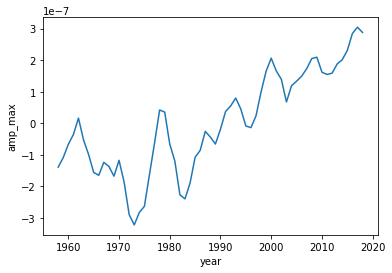

In [117]:
(ed_06_y_5yrm.amp_max- ed_06_y_5yrm.amp_max.mean()).plot()

In [73]:
X, P, df = corr_edof(ed_05_y.cont.values, ed_05_y.cont.values)

In [26]:
var_cor = {'cont': 'Number of eddies', 'amp_max': 'Max amplitude', 'life_time': 'Lifetime', 'distance': 'Distance', 'speed': 'Speed', 'scale_max': 'Diameter',
           'eke': 'EKE at 100m depth', 'drake': 'Drake Transport ', 'windst': 'Wind stress', 'windwk': 'Wind work'
          }

In [ ]:
eke

In [253]:
def plot_corr_diag(b, which='5yrm'):    
    
#     if which == 'annual':
#         data_1, data_2, data_3, data_4 = ed_06_y, ed_05_y, globals()[diag + '_6'], globals()[diag + '_5']
    if which == '5yrm':
        data_1, data_2 = ed_06_y_5yrm , ed_05_y_5yrm
        data_3, data_4 = globals()['eke6_5yrm'], globals()['eke5_5yrm']
        data_5, data_6 = globals()['drake6_5yrm'], globals()['drake5_5yrm']
        data_7, data_8 = globals()['windst6_5yrm'], globals()['windst5_5yrm']
        data_9, data_10 = globals()['windwk6_5yrm'], globals()['windwk5_5yrm']

    elif which == 'res':
        data_1, data_2 = ed_06_y - ed_06_y_5yrm, ed_05_y - ed_05_y_5yrm
        data_3, data_4 = eke_6 - eke6_5yrm, eke_5 - eke5_5yrm
        data_5, data_6 = drake_6 - drake6_5yrm, drake_5 - drake5_5yrm
        data_7, data_8 = windst_6 - windst6_5yrm, windst_5 - windst5_5yrm
        data_9, data_10 = windwk_6 - windwk6_5yrm, windwk_5 - windwk5_5yrm
        
    x_lag = np.arange(-30,31,1)
    fig, axs = plt.subplots(figsize=(20,13), ncols=2, nrows=4, gridspec_kw={
                           'width_ratios': [1, 1],
                           'height_ratios': [2.2, 0.8, 2.2, 0.8],
                       'wspace': 0.12,
                       'hspace': 0.3})
    
#     for i, ax in zip(np.arange(3,11,2), axs.flat):
#         X, P, df = corr_edof(data_1[b].values, globals()['data_' + str(i)].values)
#         Y, Q, df_2 = corr_edof(data_2[b].values, globals()['data_' + str(i+1)].values)

    X0, P0, df = corr_edof(data_1[b].values, data_3.values)
    Y0, Q0, df_2 = corr_edof(data_2[b].values, data_4.values)
    
    X1, P1, df = corr_edof(data_1[b].values, data_5.values)
    Y1, Q1, df_2 = corr_edof(data_2[b].values, data_6.values) 
    X2, P2, df = corr_edof(data_1[b].values, data_7.values)
    Y2, Q2, df_2 = corr_edof(data_2[b].values, data_8.values) 
    X3, P3, df = corr_edof(data_1[b].values, data_9.values)
    Y3, Q3, df_2 = corr_edof(data_2[b].values, data_10.values) 

    
    axs[0,0].plot(x_lag, X0, color= 'midnightblue', label = 'EXP06')
    axs[0,0].plot(x_lag, Y0, color= 'red', label = 'EXP05')
    axs[0,0].axhline(color='grey')
    axs[1,0].plot(x_lag, P0, color= 'midnightblue')
    axs[1,0].plot(x_lag, Q0, color= 'red')
        
    axs[0,1].plot(x_lag, X1, color= 'midnightblue', label = 'EXP06')
    axs[0,1].plot(x_lag, Y1, color= 'red', label = 'EXP05')
    axs[0,1].axhline(color='grey')
    axs[1,1].plot(x_lag, P1, color= 'midnightblue')
    axs[1,1].plot(x_lag, Q1, color= 'red')
    
    axs[2,0].plot(x_lag, X2, color= 'midnightblue', label = 'EXP06')
    axs[2,0].plot(x_lag, Y2, color= 'red', label = 'EXP05')
    axs[2,0].axhline(color='grey')
    axs[3,0].plot(x_lag, P2, color= 'midnightblue')
    axs[3,0].plot(x_lag, Q2, color= 'red')
    
    axs[2,1].plot(x_lag, X3, color= 'midnightblue', label = 'EXP06')
    axs[2,1].plot(x_lag, Y3, color= 'red', label = 'EXP05')
    axs[2,1].axhline(color='grey')
    axs[3,1].plot(x_lag, P3, color= 'midnightblue')
    axs[3,1].plot(x_lag, Q3, color= 'red')

    axs[0,0].set_ylabel('Cross-correlation', fontsize=18)
    axs[2,0].set_ylabel('Cross-correlation', fontsize=18)

    axs[1,0].set_ylabel('p-value', fontsize=18)
    axs[3,0].set_ylabel('p-value', fontsize=18)

    axs[3,0].set_xlabel('lag (years)', fontsize=18)
    axs[3,1].set_xlabel('lag (years)', fontsize=18)

    leg = axs[0,0].legend(fontsize=18)

    
#     axs[0,0].set_title(var_cor[diag] + ' X ' + var_cor[b], fontsize=18)
    
    axs[0,0].set_title('EKE at 100m X ' + var_cor[b], fontsize=18)
    axs[0,1].set_title('Drake transport X ' + var_cor[b], fontsize=18)
    axs[2,0].set_title('Wind stress X ' + var_cor[b], fontsize=18)
    axs[2,1].set_title('Wind work X ' + var_cor[b], fontsize=18)

    
    for ax in axs.flat:
        ax.grid()
        ax.tick_params(axis= 'x', labelsize= 18)
        ax.tick_params(axis= 'y', labelsize= 18)


    axs[1,0].set_ylim([0,1])
    axs[3,0].set_ylim([0,1])
    axs[1,1].set_ylim([0,1])
    axs[3,1].set_ylim([0,1])

    
#     plt.tight_layout()
    plt.savefig(save_path + 'corr_' + which +'_diag_' + var_cor[b] +'.png', format='png', facecolor="w",  bbox_inches='tight')

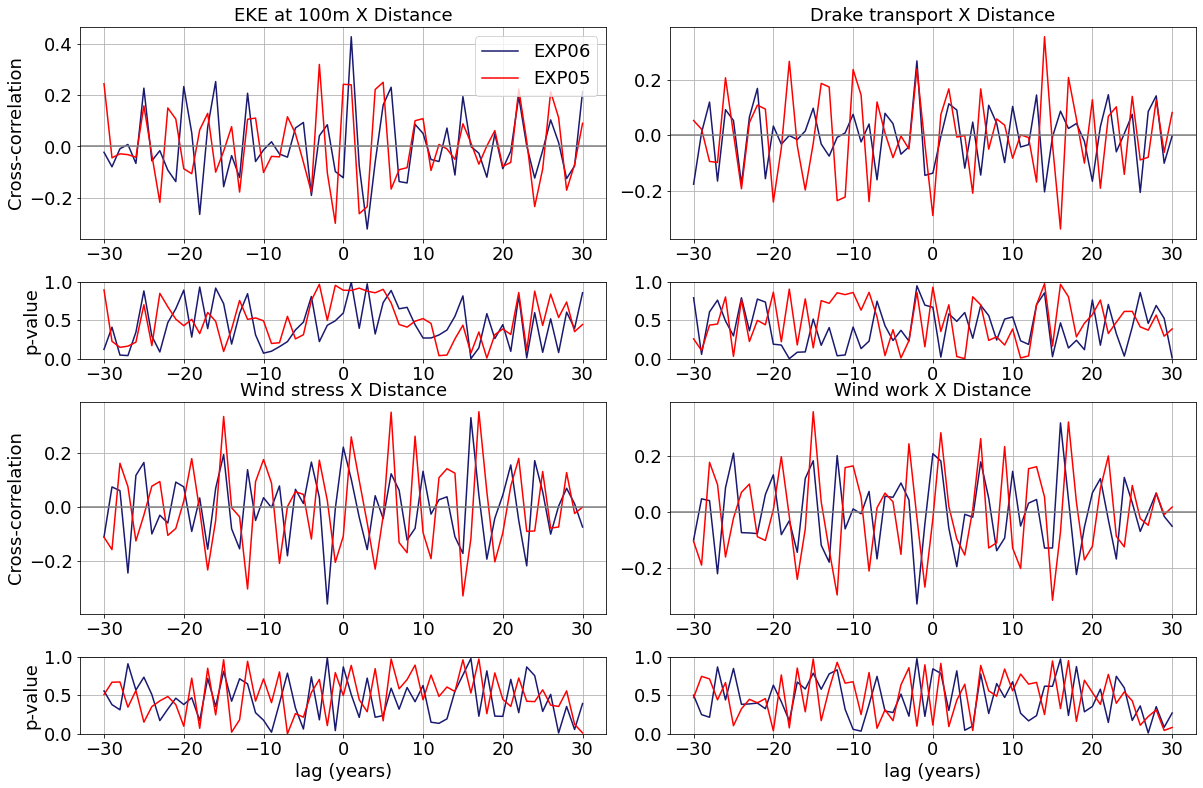

In [260]:
plot_corr_diag('distance', which='res')

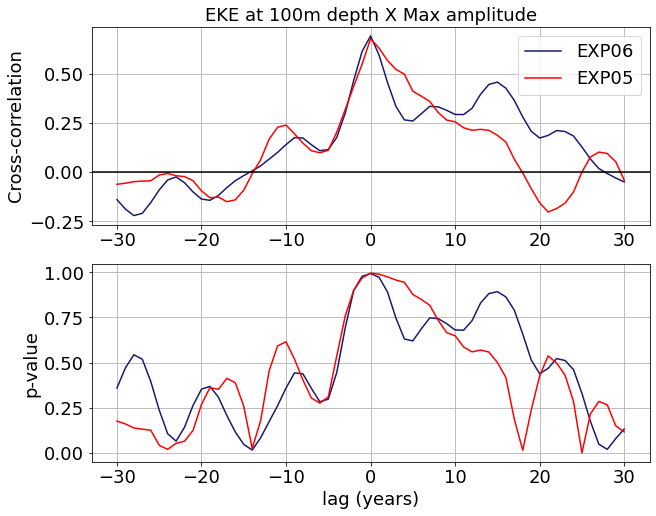

In [127]:
plot_corr_diag('eke', 'amp_max')

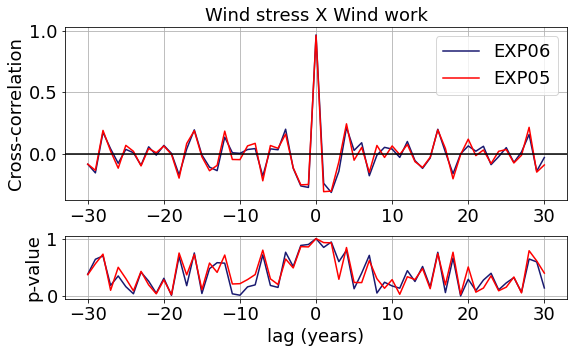

In [111]:
plot_corr_diag('windst', 'windwk', 'res')

In [105]:
def plot_corr_diag(a, b, which='5yrm'):    
    
    if which == '5yrm':
        data_1, data_2 = globals()[a + '6_5yrm'], globals()[a + '5_5yrm']#ed_06_y_5yrm, ed_05_y_5yrm
        data_3, data_4 = globals()[b + '6_5yrm'], globals()[b + '5_5yrm']#ed_06_y_5yrm, ed_05_y_5yrm
    elif which == 'res':
        data_1, data_2 = globals()[a + '_6'] - globals()[a + '6_5yrm'], globals()[a + '_5'] - globals()[a + '5_5yrm']#ed_06_y - ed_06_y_5yrm, ed_05_y - ed_05_y_5yrm
        data_3, data_4 = globals()[b + '_6'] - globals()[b + '6_5yrm'], globals()[b + '_5'] - globals()[b + '5_5yrm']
        
    X, P, df = corr_edof(data_1.values, data_3.values)
    Y, Q, df_2 = corr_edof(data_2.values, data_4.values) 
    fig, axs = plt.subplots(figsize=(9,5), ncols=1, nrows=2, gridspec_kw={
#                            'width_ratios': [1, 1],
                           'height_ratios': [2.2, 0.8],
#                        'wspace': 0.12,
                       'hspace': 0.3})
                           
    
    
    
    x_lag = np.arange(-30,31,1)
    axs[0].plot(x_lag, X, color= 'midnightblue', label = 'EXP06')
    axs[0].plot(x_lag, Y, color= 'red', label = 'EXP05')
    axs[0].axhline(color='k')
    axs[1].plot(x_lag, P, color= 'midnightblue')
    axs[1].plot(x_lag, Q, color= 'red')

    axs[0].set_ylabel('Cross-correlation', fontsize=18)
    axs[1].set_ylabel('p-value', fontsize=18)
    axs[1].set_xlabel('lag (years)', fontsize=18)
    leg = axs[0].legend(fontsize=18)

    
    axs[0].set_title(var_cor[a] + ' X ' + var_cor[b], fontsize=18)
    
    for ax in axs.flat:
        ax.grid()
        ax.tick_params(axis= 'x', labelsize= 18)
        ax.tick_params(axis= 'y', labelsize= 18)
        
    plt.savefig(save_path + 'corr_' + which +'_' + var_cor[a] + '_' + var_cor[b] +'.png', format='png', facecolor="w",  bbox_inches='tight')

In [80]:
def plot_corr_models(a, b, which='5yrm'):    
    
    if which == '5yrm':
        data_1, data_2 = ed_06_y_5yrm, ed_05_y_5yrm
    elif which == 'res':
        data_1, data_2 = ed_06_y - ed_06_y_5yrm, ed_05_y - ed_05_y_5yrm
        
        
    X, P, df = corr_edof(data_1[a].values, data_1[b].values)
    Y, Q, df_2 = corr_edof(data_2[a].values, data_2[b].values) 
    fig, axs = plt.subplots(figsize=(9,5), ncols=1, nrows=2, gridspec_kw={
#                            'width_ratios': [1, 1],
                           'height_ratios': [2.2, 0.8],
#                        'wspace': 0.12,
                       'hspace': 0.3})
                           
    
    
    
    x_lag = np.arange(-30,31,1)
    axs[0].plot(x_lag, X, color= 'midnightblue', label = 'EXP06')
    axs[0].plot(x_lag, Y, color= 'red', label = 'EXP05')
    axs[0].axhline(color='k')
    axs[1].plot(x_lag, P, color= 'midnightblue')
    axs[1].plot(x_lag, Q, color= 'red')

    axs[0].set_ylabel('Cross-correlation', fontsize=18)
    axs[1].set_ylabel('p-value', fontsize=18)
    axs[1].set_xlabel('lag (years)', fontsize=18)
    leg = axs[0].legend(fontsize=18)

    
    axs[0].set_title(var_cor[a] + ' X ' + var_cor[b], fontsize=18)
    
    for ax in axs.flat:
        ax.grid()
        ax.tick_params(axis= 'x', labelsize= 18)
        ax.tick_params(axis= 'y', labelsize= 18)
        
#     plt.savefig(save_path + 'corr_' + which +'_' + var_cor[a] + '_' + var_cor[b] +'.png', format='png', facecolor="w",  bbox_inches='tight')

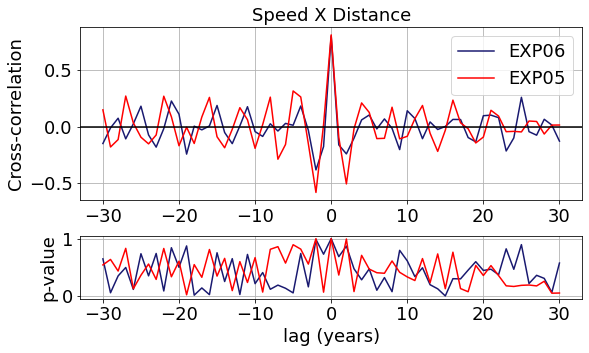

In [89]:
plot_corr_models('speed', 'distance', which='res')

In [ ]:
xr.apply_ufunc?

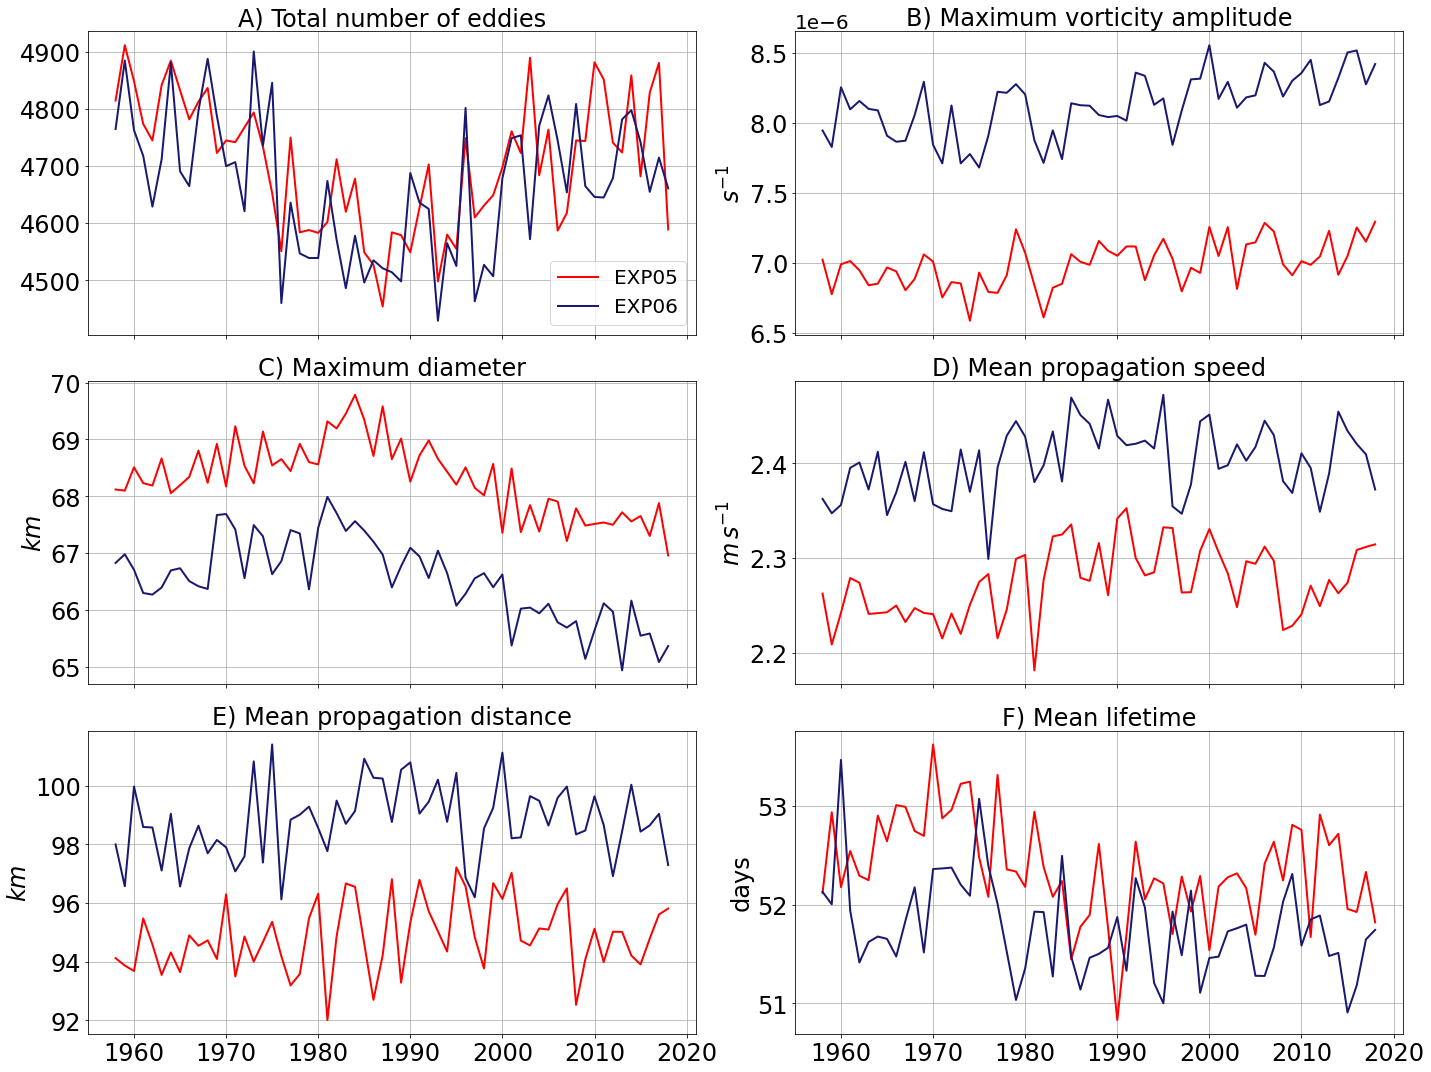

In [69]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

title = ['A) Total number of eddies', 'B) Maximum vorticity amplitude', 'C) Maximum diameter', 'D) Mean propagation speed', 'E) Mean propagation distance', 'F) Mean lifetime']
ylabel = ['', '$s^{-1}$', '$km$', '$m\,s^{-1}$', '$km$', 'days']
var = ['cont', 'amp_max', 'scale_max', 'speed', 'distance', 'life_time']
    
for ax, v, t, yla in zip(axs.flat, var, title, ylabel):
    ed_05_y.plot(x='year_i', y=v, linewidth=2, color='red', ax=ax,label='EXP05')
    ed_06_y.plot(x='year_i', y=v, ax=ax, linewidth=2, label='EXP06', color='midnightblue')
    
    ax.set_title(t, fontsize=24)
    ax.tick_params(axis= 'x', labelsize= 24)
    ax.tick_params(axis= 'y', labelsize= 24)
    ax.set_xlabel(None)
    ax.set_ylabel(yla, fontsize=24)
    ax.grid()
#     ax.axes.xaxis.set_ticklabels([])
    ax.get_legend().remove()

for ax in axs.flat[0:4]:
    ax.axes.xaxis.set_ticklabels([])

    
# for ax in axs[4:6]:
# axs[3].set_xlabel('year', fontsize=24)
# axs[5].set_xlabel('year', fontsize=24)

# ax.axes.xaxis.set_ticklabels(
leg = axs[0,0].legend(loc='lower right', fontsize=20)
axs[0,1].yaxis.offsetText.set_fontsize(20)

    
plt.tight_layout(h_pad=1.80)
save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/'
# plt.savefig(save_path + 'annual_timeseries_1958_2018.png', format='png', facecolor="w",  bbox_inches='tight')

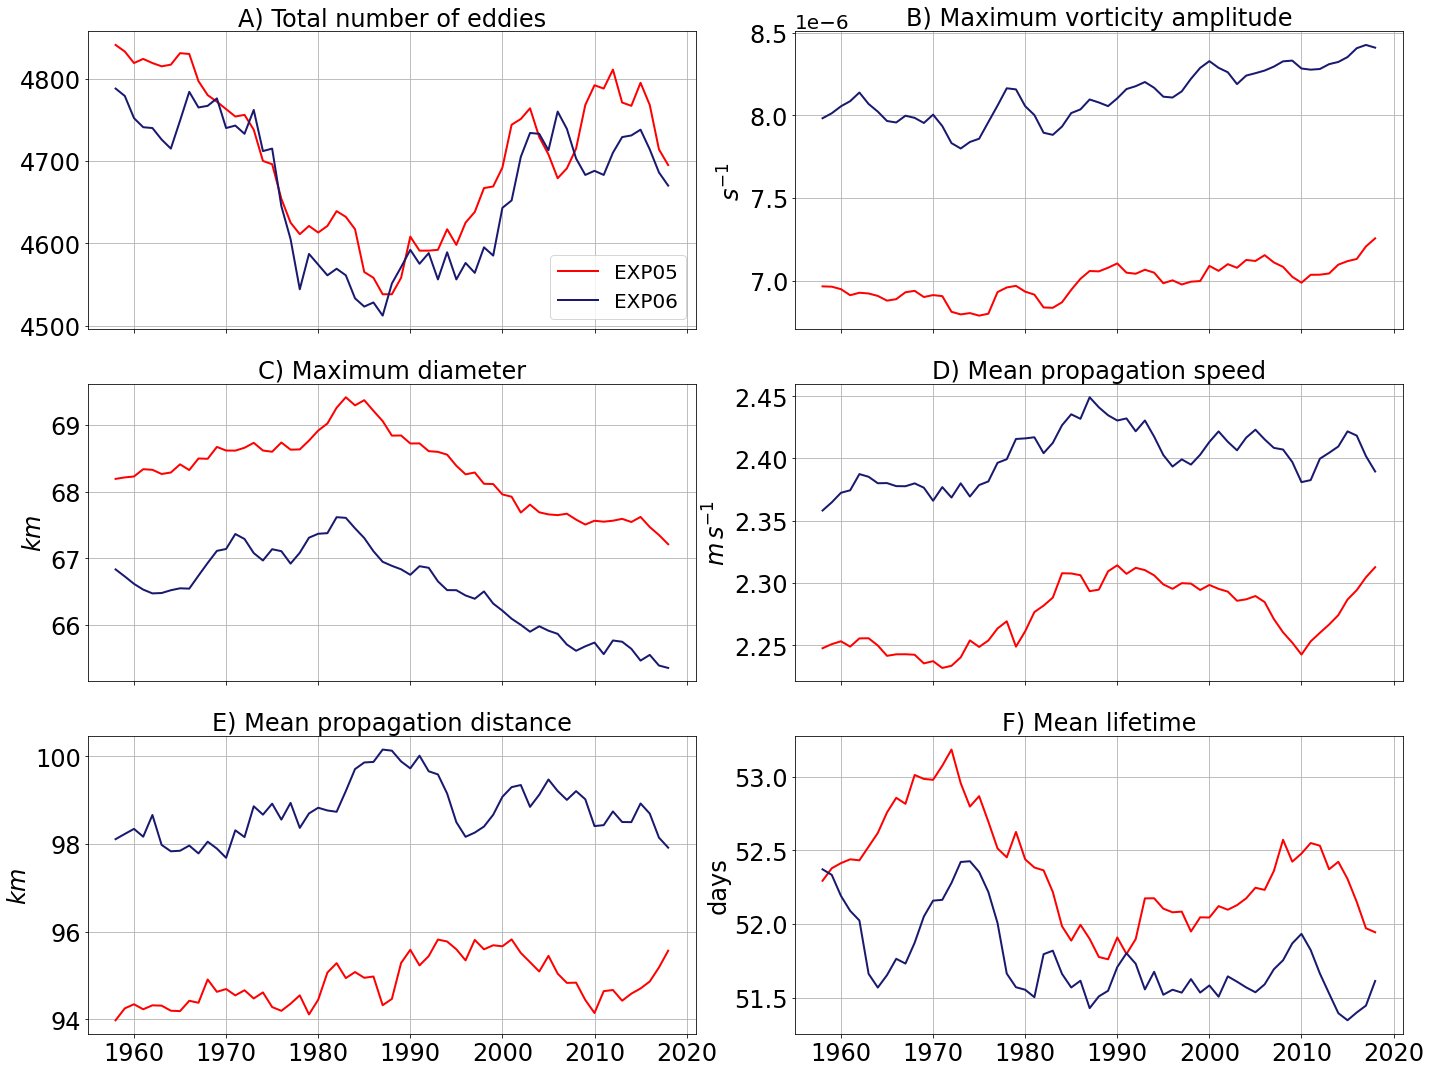

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

title = ['A) Total number of eddies', 'B) Maximum vorticity amplitude', 'C) Maximum diameter', 'D) Mean propagation speed', 'E) Mean propagation distance', 'F) Mean lifetime']
ylabel = ['', '$s^{-1}$', '$km$', '$m\,s^{-1}$', '$km$', 'days']
var = ['cont', 'amp_max', 'scale_max', 'speed', 'distance', 'life_time']
    
for ax, v, t, yla in zip(axs.flat, var, title, ylabel):
    ed_05_y_rmean_5year[v].plot(linewidth=2, color='red', ax=ax,label='EXP05')
    ed_06_y_rmean_5year[v].plot(ax=ax, linewidth=2, label='EXP06', color='midnightblue')
    
    ax.set_title(t, fontsize=24)
    ax.tick_params(axis= 'x', labelsize= 24)
    ax.tick_params(axis= 'y', labelsize= 24)
    ax.set_xlabel(None)
    ax.set_ylabel(yla, fontsize=24)
    ax.grid()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.get_legend().remove()

for ax in axs.flat[0:4]:
    ax.axes.xaxis.set_ticklabels([])

    
# for ax in axs[4:6]:
# axs[3].set_xlabel('year', fontsize=24)
# axs[5].set_xlabel('year', fontsize=24)

# ax.axes.xaxis.set_ticklabels(
leg = axs[0,0].legend(loc='lower right', fontsize=20)
axs[0,1].yaxis.offsetText.set_fontsize(20)

    
plt.tight_layout(h_pad=1.80)
save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/'
plt.savefig(save_path + '5y_runningmean_timeseries_1958_2018.png', format='png', facecolor="w",  bbox_inches='tight')

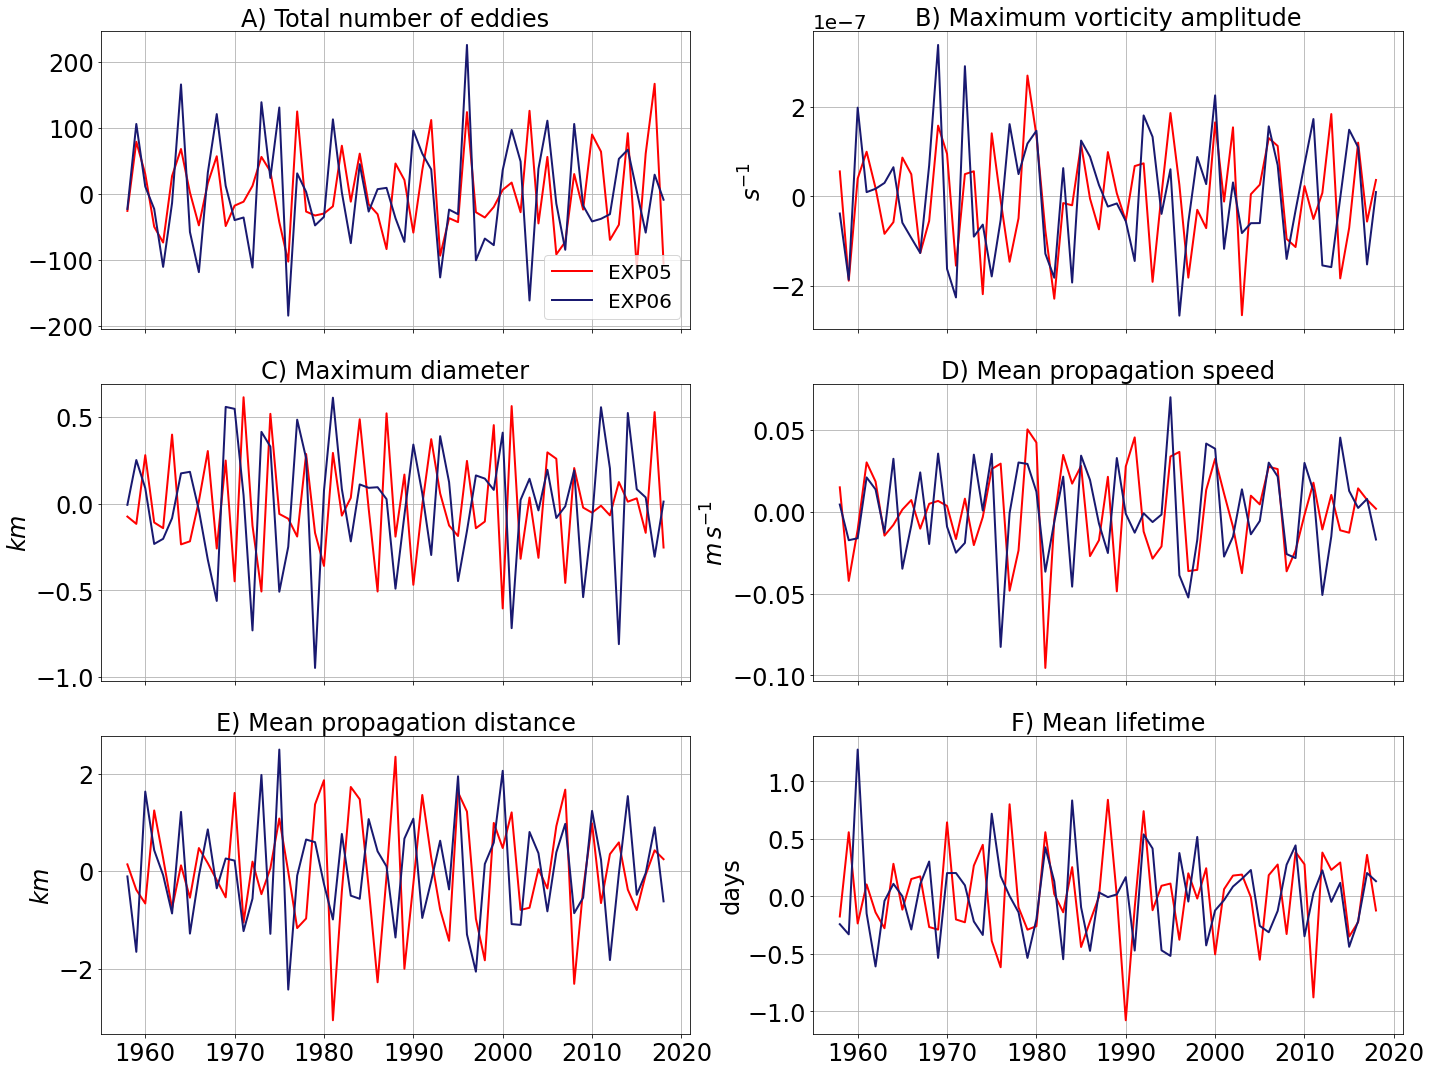

In [57]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

title = ['A) Total number of eddies', 'B) Maximum vorticity amplitude', 'C) Maximum diameter', 'D) Mean propagation speed', 'E) Mean propagation distance', 'F) Mean lifetime']
ylabel = ['', '$s^{-1}$', '$km$', '$m\,s^{-1}$', '$km$', 'days']
var = ['cont', 'amp_max', 'scale_max', 'speed', 'distance', 'life_time']
    
for ax, v, t, yla in zip(axs.flat, var, title, ylabel):
    (ed_05_y[v] - ed_05_y_rmean_5year[v]).plot(linewidth=2, color='red', ax=ax,label='EXP05')
    (ed_06_y[v] - ed_06_y_rmean_5year[v]).plot(ax=ax, linewidth=2, label='EXP06', color='midnightblue')
    
    ax.set_title(t, fontsize=24)
    ax.tick_params(axis= 'x', labelsize= 24)
    ax.tick_params(axis= 'y', labelsize= 24)
    ax.set_xlabel(None)
    ax.set_ylabel(yla, fontsize=24)
    ax.grid()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.get_legend().remove()

for ax in axs.flat[0:4]:
    ax.axes.xaxis.set_ticklabels([])

    
# for ax in axs[4:6]:
# axs[3].set_xlabel('year', fontsize=24)
# axs[5].set_xlabel('year', fontsize=24)

# ax.axes.xaxis.set_ticklabels(
leg = axs[0,0].legend(loc='lower right', fontsize=20)
axs[0,1].yaxis.offsetText.set_fontsize(20)

    
plt.tight_layout(h_pad=1.80)
save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/'
plt.savefig(save_path + 'annual-5yrunningmean_timeseries_1958_2018.png', format='png', facecolor="w",  bbox_inches='tight')

### histograms

In [ ]:
# Histograms of EXP06, EXP05 and observations (maybe more than one), ACC mask and whole 30S-68S → 1 figure (diameter, amplitude, speed, length, lifetime)

In [57]:
(ed_06.distance.values[0] * 1e5) / (ed_06.life_time.values[0] * 24 *3600)

1.290852453684301

In [ ]:
ed_06.distance.values[0] * 1e5

In [53]:
ed_06.life_time.values[0]

45.0

In [337]:
# ADD TITLES
var_dict = {'amp_max':{'int': 3e-7, 'xlim': [0, 2*1e-5], 'title': 'Models \nA) Max. amplitude', 'ylab': 's$^{-1}$'},
            'scale_max': {'int': 1, 'xlim': [20, 140], 'title': 'C) Max. diameter', 'ylab': 'km'},
           'speed': {'int': 0.1, 'xlim': [0, 5], 'title': 'E) Mean speed', 'ylab': 'cm$\,$s$^{-1}$'},
           'distance': {'int': 5, 'xlim': [0, 400], 'title': 'G) Distance', 'ylab': 'km'},
           'life_time': {'int': 15, 'xlim': [30, 200], 'title': 'I) Lifetime', 'ylab': 'days'}}

In [357]:
meta_dict = {'amplitude':{'int': 0.5, 'xlim': [0, 30], 'title': 'Observations \nB) Max. amplitude', 'ylab': 'cm'},
            'speed_radius': {'int': 1, 'xlim': [30, 160], 'title': 'D) Max. diameter', 'ylab': 'km'},
           'speed_calculated': {'int': 0.1, 'xlim': [0, 5], 'title': 'F) Mean speed', 'ylab': 'cm$\,$s$^{-1}$'},
           'distance': {'int': 5, 'xlim': [0, 400], 'title': 'H) Distance', 'ylab': 'km'},
           'lifetime': {'int': 15, 'xlim': [30, 200], 'title': 'J) Lifetime', 'ylab': 'days'}}

In [101]:
meta = meta.where(meta.lifetime >= 30, drop=True)

In [125]:
bins_6 = math.ceil(((meta['lifetime'].max()/7 )- (meta['lifetime'].min()/7)) / 1)
y_ed6, bins_ed6 = np.histogram((meta['lifetime']/7), bins=bins_6)
bincenters_e6= 0.5*(bins_ed6[1:]+bins_ed6[:-1])

In [175]:
((meta['distance'] * 1e5) / (meta['lifetime'] * 24 *3600)).values

array([4.45237706, 3.48330312, 4.27734658, ..., 3.42853793, 4.62876605,
       3.55183063])

In [177]:
meta = meta.update({'speed_calculated': ((meta['distance'] * 1e5) / (meta['lifetime'] * 24 *3600))})

In [293]:
meta['amplitude'] = meta['amplitude'] * 1e2

In [305]:
meta['speed_radius'] = meta['speed_radius'] / 2

In [5]:
cyc['diam_max'] = cyc_d['diameter']

In [6]:
ant['diam_max'] = ant_d['diameter']

In [7]:
# concatenating ivy's cyclinic and anticyclonic data for histogram
frenger = pd.concat([cyc,ant], ignore_index=True)

In [8]:
frenger = frenger.drop(columns=['diameter']).rename(columns={'diam_max': 'diameter'})

In [15]:
frenger.distance.mean(), frenger.distance.std()

(129.01563213936188, 126.24057554645763)

In [282]:
# changing name of columns to match meta data
frenger = frenger.rename(columns={'speed': 'speed_calculated', 'diameter': 'speed_radius'})

In [12]:
frenger

,lifetime,lon,lat,lat_e,lon_e,distance,speed,diameter
0,70.0,28.812500,-53.125000,-53.191667,31.358333,169.785957,2.807307,94.034467
1,63.0,31.240385,-49.509615,-49.525000,34.025000,200.892601,3.690708,94.617858
2,49.0,33.488636,-53.965909,-53.486111,34.069444,65.578698,1.549006,126.190616
3,28.0,48.736111,-45.847222,-44.925000,48.525000,103.793304,4.290398,82.988895
4,56.0,57.875000,-45.750000,-45.548913,59.396739,120.299114,2.486341,139.211448
...,...,...,...,...,...,...,...,...
54039,28.0,139.625000,-63.160714,-63.017857,140.196429,32.831651,1.357128,72.767598
54040,28.0,188.303571,-62.767857,-62.812500,188.875000,29.454834,1.217544,56.139673
54041,28.0,255.196429,-64.732143,-64.517857,255.696429,33.673247,1.391917,61.507728
54042,28.0,287.500000,-64.791667,-64.625000,288.500000,50.957958,2.106397,57.978881


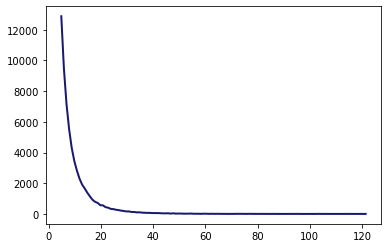

In [129]:
plt.plot(bincenters_e6, y_ed6, label= 'EXP06', color='midnightblue', linewidth=2)

In [355]:
# CHANGE XLIMS, ADD OBSERVATIONS
def plot_histogram():
    
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
    count=0    
        
    for idx, v in enumerate(var_dict.keys()):
        bins_6 = math.ceil((ed_06[v].max() - ed_06[v].min()) / var_dict[v]['int'])
        y_ed6, bins_ed6 = np.histogram(ed_06[v], bins=bins_6)
        bincenters_e6= 0.5*(bins_ed6[1:]+bins_ed6[:-1])

        bins_5 = math.ceil((ed_05[v].max() - ed_05[v].min()) / var_dict[v]['int'])
        y_ed5, bins_ed5 = np.histogram(ed_05[v], bins=bins_5)
        bincenters_e5= 0.5*(bins_ed5[1:]+bins_ed5[:-1])       
        
        axs[idx,0].plot(bincenters_e6, y_ed6, label= 'EXP06', color='midnightblue', linewidth=2)
        axs[idx,0].plot(bincenters_e5, y_ed5, label= 'EXP05', color='red', linewidth=2)
        
        axs[idx,0].axvline(x=ed_06[v].mean(), color='mediumblue', linestyle='--', linewidth=2)
        axs[idx,0].axvline(x=ed_05[v].mean(), color='red', linestyle='--', linewidth=2)
        
        axs[idx,0].set_xlim(left=var_dict[v]['xlim'][0], right=var_dict[v]['xlim'][1])
        
        axs[idx,0].set_xlabel(var_dict[v]['ylab'], fontsize=18)
        axs[idx,0].set_title(var_dict[v]['title'],fontsize=18)
        
    for idy, vari in enumerate(meta_dict.keys()):
        bins_meta = math.ceil((meta[vari].max() - meta[vari].min()) / meta_dict[vari]['int'])
        y_meta, bins_meta = np.histogram(meta[vari], bins=bins_meta)
        bincenters_meta= 0.5*(bins_meta[1:]+bins_meta[:-1])
        
        axs[idy,1].axvline(x=meta[vari].mean(), color='k', linestyle='--', linewidth=2)
        
        axs[idy,1].plot(bincenters_meta, y_meta, label= 'META', color='k', linewidth=2)
        axs[idy,1].set_xlim(left=meta_dict[vari]['xlim'][0], right=meta_dict[vari]['xlim'][1])
        axs[idy,1].set_xlabel(meta_dict[vari]['ylab'], fontsize=20)
        axs[idy,1].set_title(meta_dict[vari]['title'],fontsize=20)

        if idy >= 1:
            bins_ivy = math.ceil((frenger[vari].max() - frenger[vari].min()) / meta_dict[vari]['int'])
            y_ivy, bins_ivy = np.histogram(frenger[vari], bins=bins_ivy)
            bincenters_ivy= 0.5*(bins_ivy[1:]+bins_ivy[:-1])

            axs[idy,1].axvline(x=frenger[vari].mean(), color='darkorchid', linestyle='--', linewidth=2)

            axs[idy,1].plot(bincenters_ivy, y_ivy, label= 'F_18', color='darkorchid', linewidth=2)
        
        
    leg = axs[0,0].legend(fontsize=20)
    leg2 = axs[1,1].legend(fontsize=20)
    for ax in axs.flat:
        ax.tick_params(axis= 'x', labelsize= 20)
        ax.tick_params(axis= 'y', labelsize=20)
        ax.set_ylim(bottom=0)
#         ax.set_xlabel(None)
        ax.grid()
    axs[2,0].set_ylabel('Number of eddies', fontsize=22)
    plt.tight_layout()
    
    
    
    plt.savefig(save_path + 'hist_models_obs.png', format='png', facecolor="w",  bbox_inches='tight')

In [322]:
save_path

'/scratch/usr/shkifmmp/notebooks/shared-notebooks/fig_paper/'

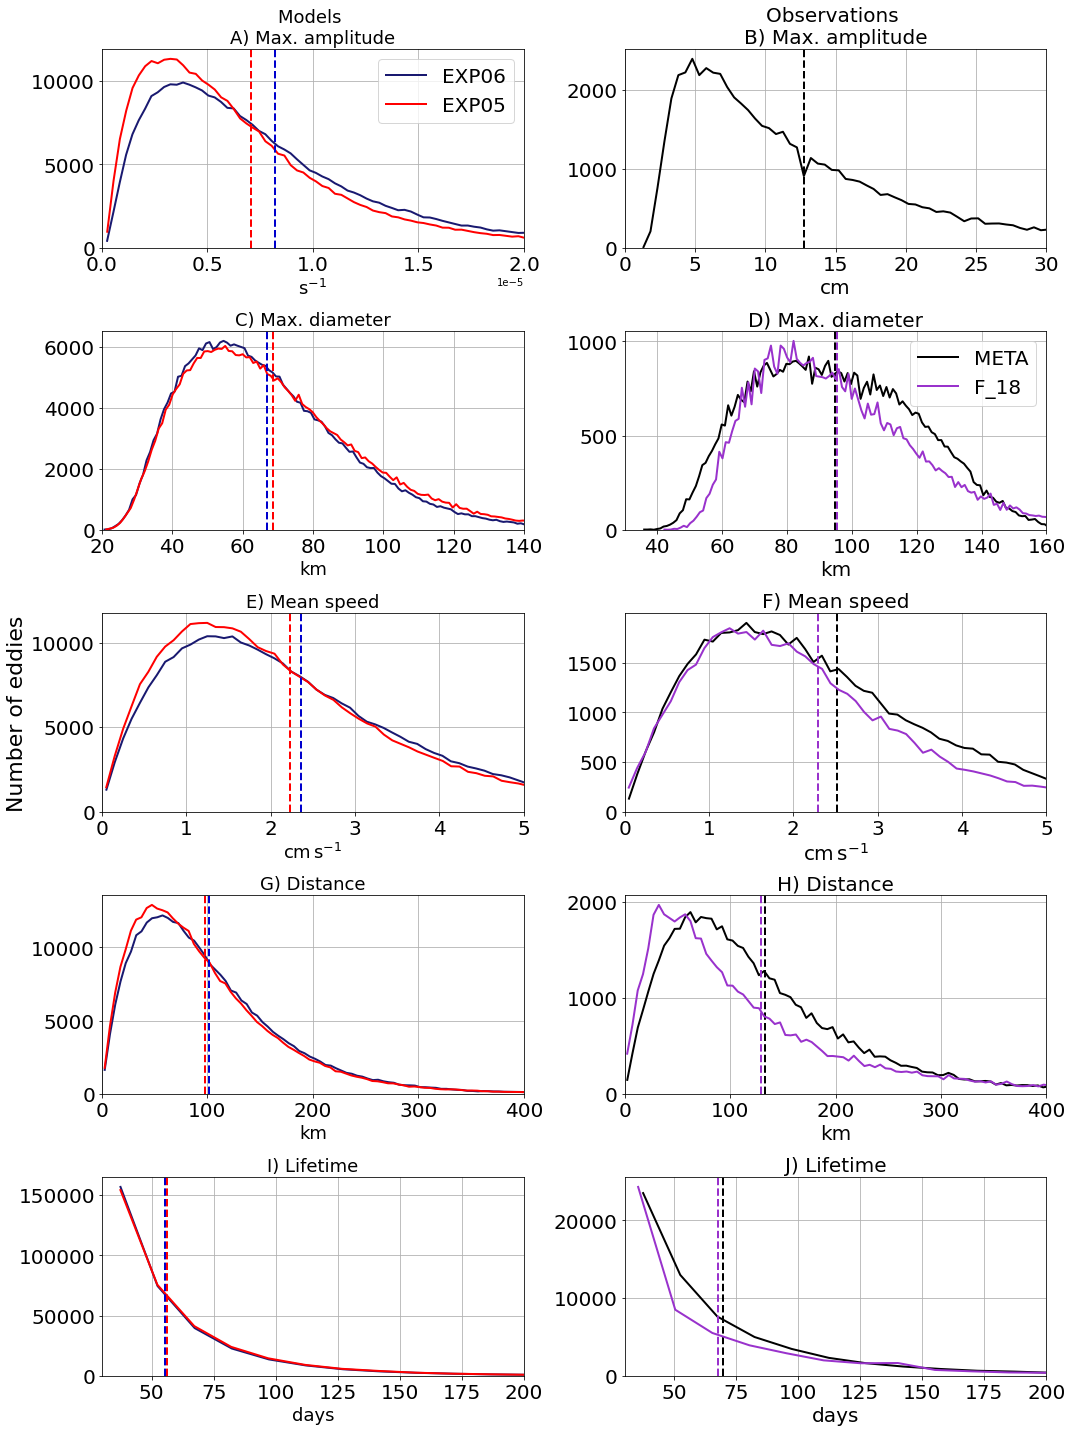

In [358]:
plot_histogram()

In [345]:
plt.axvline?

Signature: plt.axvline(x=0, ymin=0, ymax=1, **kwargs)
Docstring:
Add a vertical line across the Axes.

Parameters
----------
x : float, default: 0
    x position in data coordinates of the vertical line.

ymin : float, default: 0
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

ymax : float, default: 1
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

Returns
-------
`~matplotlib.lines.Line2D`

Other Parameters
----------------
**kwargs
    Valid keyword arguments are `.Line2D` properties, with the
    exception of 'transform':

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
    alpha: scalar or None
    animated: bool
    antialiased or aa: bool
    clip_box: `.Bbox`
    clip_on: bool
    clip_path: Patch or (Path, Transform) or None
    color or c: color
    contains: unknown
    dash_capstyle: `.CapStyle` or {'butt'

In [ ]:
axs[idy,1].axvline

(10.0, 2770.95)

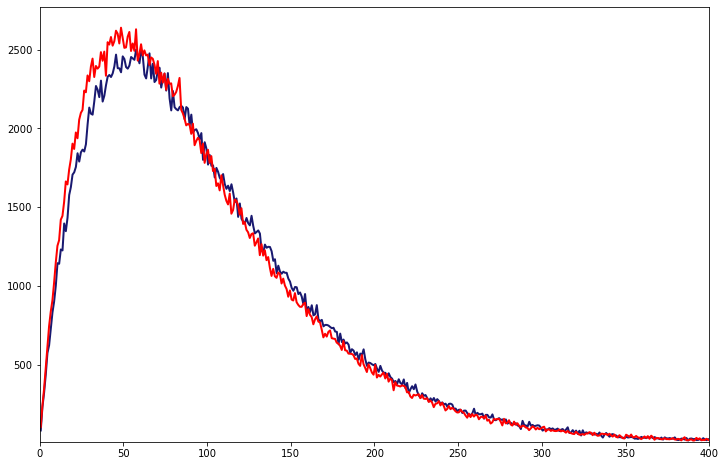

In [31]:
# bins_6 = math.ceil((ed_06['life_time'].astype('timedelta64[D]').max() 
#                                        - ed_06['life_time'].astype('timedelta64[D]').min()) / interval)
interval=1
bins_6 = math.ceil((ed_06['distance'].max() 
                                       - ed_06['distance'].min()) / interval)
y_ed6, bins_ed6 = np.histogram(ed_06['distance'], bins=bins_6)

bincenters_e6= 0.5*(bins_ed6[1:]+bins_ed6[:-1])

bins_5 = math.ceil((ed_05['distance'].max() 
                                       - ed_05['distance'].min()) / interval)
y_ed5, bins_ed5 = np.histogram(ed_05['distance'], bins=bins_5)

bincenters_e5= 0.5*(bins_ed5[1:]+bins_ed5[:-1])

fig, axs = plt.subplots(figsize=(12,8))
axs.plot(bincenters_e6, y_ed6, label= 'EXP06', color='midnightblue', linewidth=2)
axs.plot(bincenters_e5, y_ed5, label= 'EXP05', color='red', linewidth=2)


axs.set_xlim(right=400, left=0)
axs.set_ylim(bottom=10)

In [6]:
np.histogram?

Signature:
np.histogram(
    a,
    bins=10,
    range=None,
    normed=None,
    weights=None,
    density=None,
)
Docstring:
Compute the histogram of a dataset.

Parameters
----------
a : array_like
    Input data. The histogram is computed over the flattened array.
bins : int or sequence of scalars or str, optional
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines a monotonically increasing array of bin edges,
    including the rightmost edge, allowing for non-uniform bin widths.

    .. versionadded:: 1.11.0

    If `bins` is a string, it defines the method used to calculate the
    optimal bin width, as defined by `histogram_bin_edges`.

range : (float, float), optional
    The lower and upper range of the bins.  If not provided, range
    is simply ``(a.min(), a.max())``.  Values outside the range are
    ignored. The first element of the range must be less than or
    equal to the s

In [5]:
math.ceil?

Signature: math.ceil(x, /)
Docstring:
Return the ceiling of x as an Integral.

This is the smallest integer >= x.
Type:      builtin_function_or_method


In [102]:
data_05_2= data_05_2.assign(amp_mean=stat_05_02['amp_mean'], distance=stat_05_02['distance'], scale_mean= stat_05_02['scale_mean'])

In [71]:
data_05_2 = stat_05_02[['time','type', 'life_time', 'speed', 'scale_max', 'amp_max']].copy()

In [12]:
np.where(np.isnan(data_5["year_i"].values))

(array([     0,      1,      2, ..., 248427, 248428, 248429]),)

In [180]:
data_05.describe()

,life_time,speed,scale_max,amp_max,year_i,year_f,amp_mean,distance,scale_mean
count,248430,248430.000000,248430.000000,2.484300e+05,248430.000000,248430.000000,2.484300e+05,248430.000000,248430.000000
mean,67 days 05:54:33.256853038,2.273442,73.665473,7.905844e-06,1977.240688,1977.421620,5.207580e-06,115.537678,59.835314
std,53 days 06:00:23.458347184,1.533960,28.489316,6.383503e-06,11.568033,11.568251,4.213902e-06,91.387382,22.859343
min,30 days 00:00:00,0.002389,19.908334,1.140841e-07,1958.000000,1958.000000,2.975616e-08,0.204672,18.951270
25%,35 days 00:00:00,1.136720,51.840729,3.429724e-06,1967.000000,1967.000000,2.248320e-06,52.757027,42.526384
50%,50 days 00:00:00,1.942114,68.338359,6.257600e-06,1977.000000,1977.000000,4.099596e-06,92.665456,55.326573
75%,80 days 00:00:00,3.064417,90.606421,1.045126e-05,1987.000000,1988.000000,6.882717e-06,151.931475,72.595113
max,3683 days 00:00:00,13.254281,183.341835,8.436879e-05,1997.000000,1997.000000,4.480990e-05,1292.874545,173.618061


In [ ]:
for i in data_05_1.index:
    data_05_1.loc[i, 'year_i'] = pd.to_datetime(data_05_1.time.loc[i][0]).year
    data_05_1.loc[i, 'year_f'] = pd.to_datetime(data_05_1.time.loc[i][-1]).year

In [ ]:
for i in data_05_2.index:
    data_05_2.loc[i, 'year_i'] = pd.to_datetime(data_05_2.time.loc[i][0]).year
    data_05_2.loc[i, 'year_f'] = pd.to_datetime(data_05_2.time.loc[i][-1]).year

In [68]:
data_05_1.loc[436702, 'year_i'] = pd.to_datetime(data_05_1.time.loc[436702][0]).year

In [58]:
data_05_1.loc[431524, 'year_f'] = pd.to_datetime(data_05_1.time.iloc[431524][-1]).year

In [55]:
pd.to_datetime(data_05_1.time.iloc[431524][-1]).year

1977

In [75]:
data_05_2

,time,type,life_time,speed,scale_max,amp_max,year_i,year_f
1611,"[1978-01-08T12:00:00.000000000, 1978-01-13T12:...",anticyclonic,10 days,0.240417,18.259139,1.392770e-06,1978.0,1978.0
1612,"[1978-01-08T12:00:00.000000000, 1978-01-13T12:...",anticyclonic,100 days,0.109788,30.210557,5.886391e-06,1978.0,1978.0
1613,"[1978-01-08T12:00:00.000000000, 1978-01-13T12:...",anticyclonic,40 days,2.146260,52.377466,5.821783e-06,1978.0,1978.0
1614,"[1978-01-08T12:00:00.000000000, 1978-01-13T12:...",cyclonic,180 days,0.195996,24.870280,1.826120e-06,1978.0,1978.0
1615,"[1978-01-08T12:00:00.000000000, 1978-01-13T12:...",cyclonic,10 days,5.999985,30.971657,3.465632e-06,1978.0,1978.0
...,...,...,...,...,...,...,...,...
430468,"[1997-12-19T12:00:00.000000000, 1997-12-24T12:...",cyclonic,5 days,4.614782,29.967260,2.763548e-06,1997.0,1997.0
430472,"[1997-12-19T12:00:00.000000000, 1997-12-24T12:...",cyclonic,5 days,3.167708,21.878599,6.226394e-07,1997.0,1997.0
430473,"[1997-12-19T12:00:00.000000000, 1997-12-24T12:...",cyclonic,5 days,5.574938,61.103796,1.000343e-05,1997.0,1997.0
430477,"[1997-12-19T12:00:00.000000000, 1997-12-24T12:...",anticyclonic,5 days,3.431616,18.414626,1.826001e-06,1997.0,1997.0
